In [61]:
!pip install G

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from warnings import simplefilter
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

# Fraud detection in online transactions


## Loading data

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
df = pd.read_csv('C:/Users/sanke/Desktop/Fraud.csv')

## Data Structure

In [4]:
df.shape

(6362620, 11)

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data cleaning

* Checking for null values
* checking for duplicates
* Checking on data types

In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

# Initial Analysis and visualization

<h2>Studying Correlation:

In [9]:
cor = df.corr()
cor

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


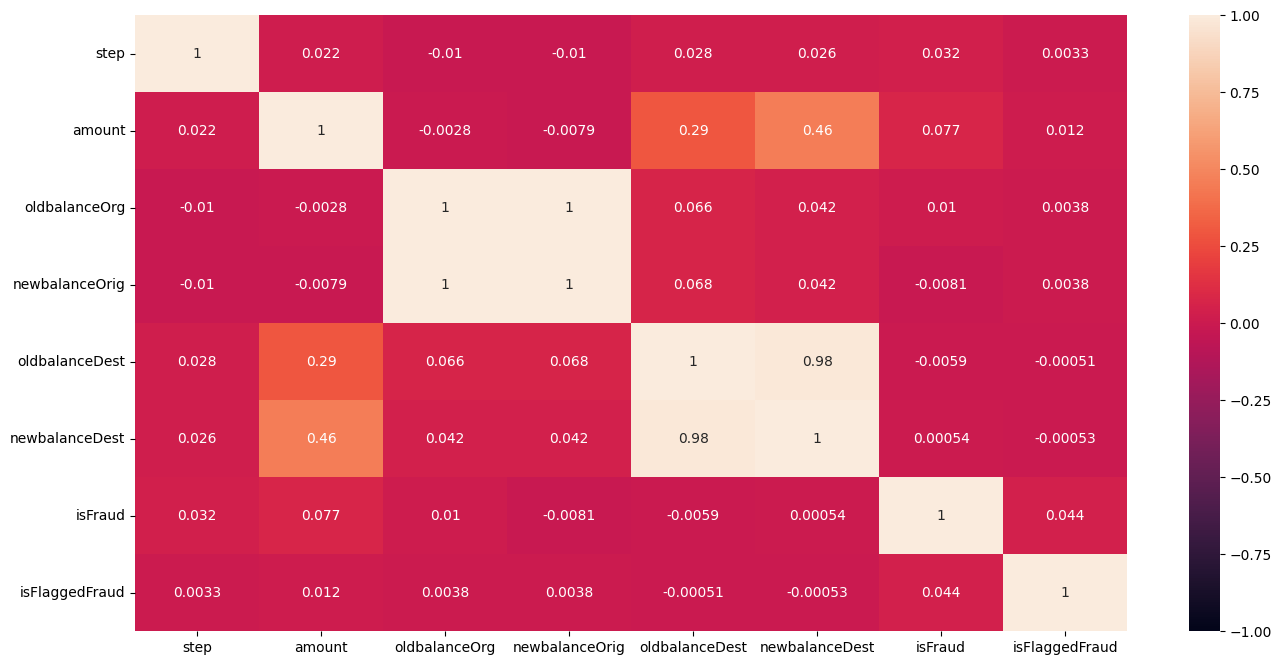

In [10]:
plt.figure(figsize = (16,8))
ax=sns.heatmap(df.corr(method ='pearson'),annot=True,vmin=-1, vmax=1)

## time stamp

In [11]:
df['day_of_month'] =np.ceil(df['step']/24)

**there is no strong correlation between any of the column and the target variable**


**Strong correlation between old and new balance in source and destination, So in modeling we can use only one column from source and destination**


## Transactions Type v/s Target

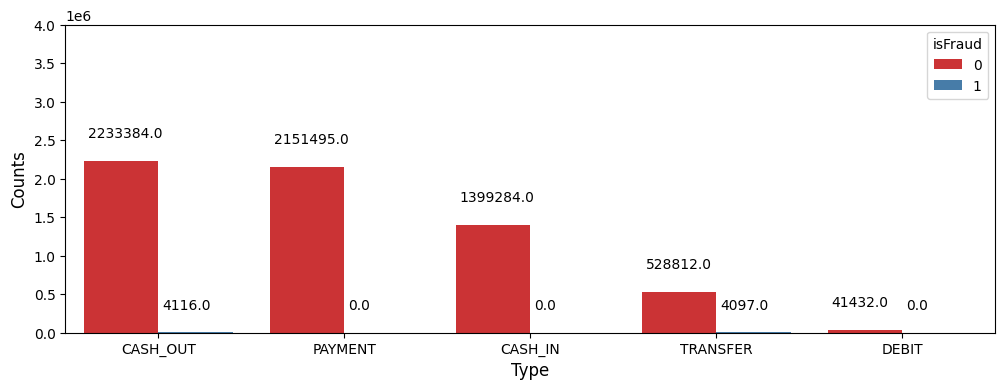

In [12]:
plt.figure(figsize=(12,4))

ax = sns.countplot(x="type", data=df, palette="Set1", order=df['type'].value_counts().index, hue='isFraud')

plt.xlabel("Type", fontsize= 12)
plt.ylabel("Counts", fontsize= 12)
plt.ylim(0, 4000000)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.02, p.get_height()+300000))
    
plt.show()

## types of transactions where fraud occurs

In [13]:
df[df['isFraud']==1]['type'].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

**Fradulant transactions only occurs in cash out and transfer transactions**

In [14]:
ct = df[df['type'].isin(['CASH_OUT','TRANSFER'])]

In [15]:
fraud_in_cash = ct[ct['type'] == 'CASH_OUT']
fraud_in_cash[fraud_in_cash['isFraud'] == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day_of_month
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0,1.0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0,1.0
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.00,12145.85,1,0,1.0
724,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.00,9291619.62,1,0,1.0
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.00,2444985.19,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362611,742,CASH_OUT,63416.99,C994950684,63416.99,0.0,C1662241365,276433.18,339850.17,1,0,31.0
6362613,743,CASH_OUT,1258818.82,C1436118706,1258818.82,0.0,C1240760502,503464.50,1762283.33,1,0,31.0
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0,31.0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0,31.0


In fraudulant transactions of type cash out, it's noticed that the origin balance goes back to zero after the cash out 

In [16]:
fraud_in_transfer = ct[ct['type'] == 'TRANSFER']
fraud_in_transfer[fraud_in_transfer['isFraud'] == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day_of_month
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.0,1,0,1.0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.0,0.0,1,0,1.0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.0,0.0,1,0,1.0
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.0,0.0,1,0,1.0
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.0,0.0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.0,C1812552860,0.0,0.0,1,0,31.0
6362612,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.0,C1470998563,0.0,0.0,1,0,31.0
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.0,C1850423904,0.0,0.0,1,0,31.0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.0,0.0,1,0,31.0


in Fraudulant transaction of type transfer it's noticed that the whole amount in the account of origin is emptied, with no access on Destination balance

<AxesSubplot: xlabel='day_of_month', ylabel='amount'>

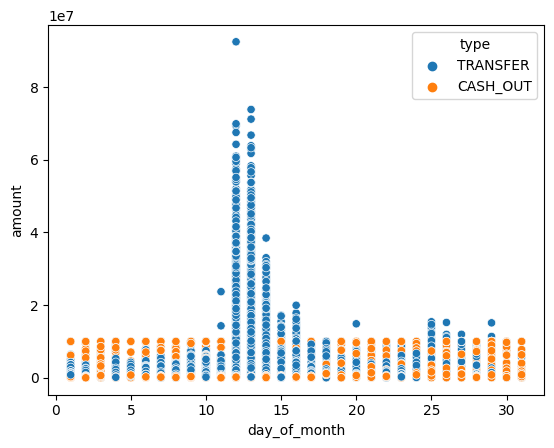

In [17]:
sns.scatterplot(data= ct , x = 'day_of_month', y='amount',hue = 'type')

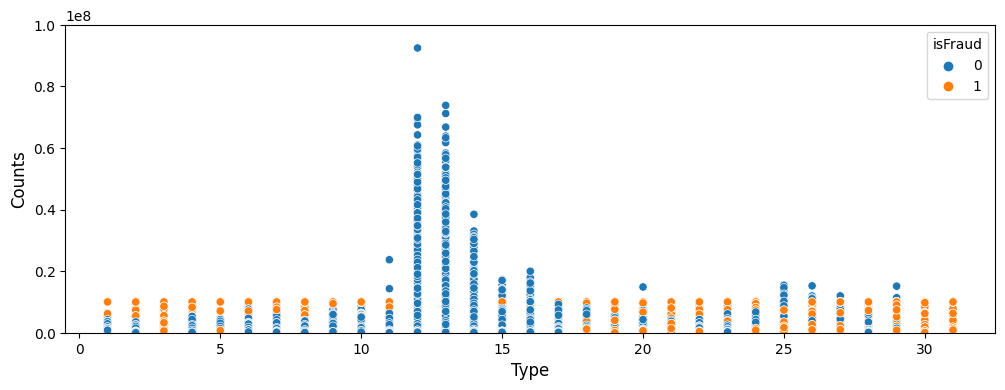

In [18]:
plt.figure(figsize=(12,4))

ax = sns.scatterplot(data= ct , x = 'day_of_month', y='amount',hue = 'isFraud')

plt.xlabel("Type", fontsize= 12)
plt.ylabel("Counts", fontsize= 12)
plt.ylim(0, 100000000)
plt.show()

So we can see no fraud transaction occur over transaction amount = 1.1 x 10**6

In [19]:
gb_step= df[df['isFraud']==1]
data = gb_step['day_of_month'].value_counts().reset_index()
data = data.rename(columns = {'index':'month', 'day_of_month':'#fraud'}).sort_values(by='month')

data ['#transaction'] = df['day_of_month'].value_counts()
data ['#fraud/day'] = data['#fraud'] / data['#transaction']

<AxesSubplot: xlabel='month', ylabel='#fraud/day'>

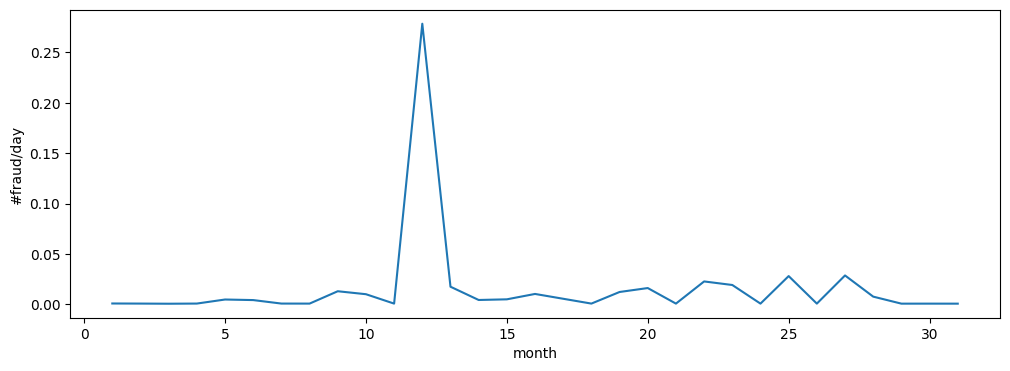

In [20]:
plt.figure(figsize=(12,4))
sns.lineplot(data=data, x='month', y='#fraud/day')

So no relations can be estimated for # of frauds over time

## visualizing Data Distribution


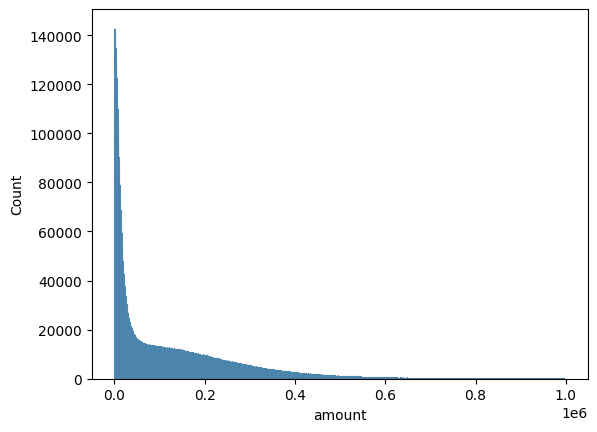

In [21]:
bin_values = np.arange(start=0, stop=1000000, step=1000)
g = sns.histplot(df['amount'],bins=bin_values)

<AxesSubplot: xlabel='newbalanceDest', ylabel='Count'>

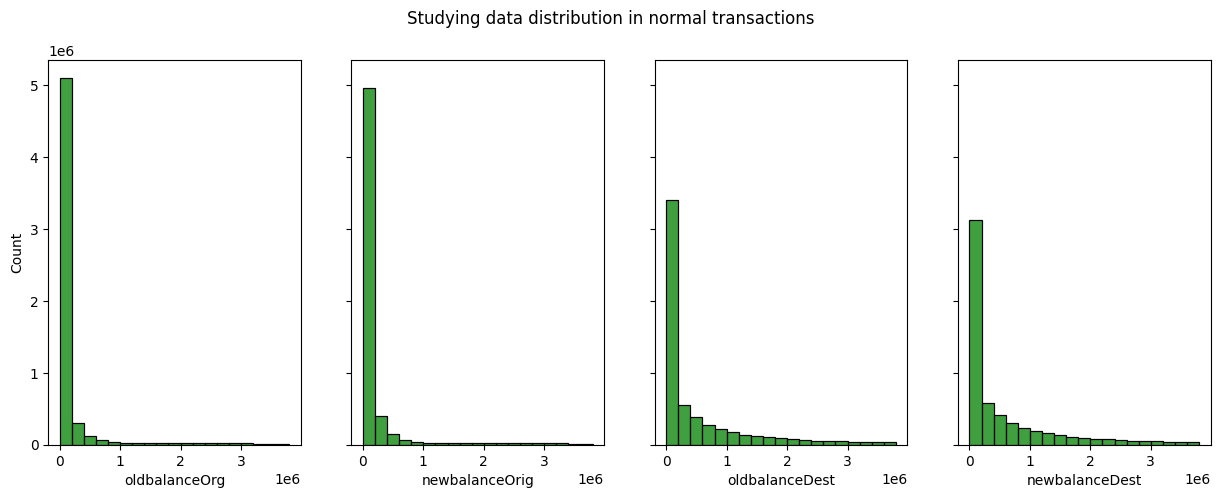

In [22]:
bin_values = np.arange(start=0, stop=4000000, step=200000)
fig, axes = plt.subplots(1, 4,figsize=(15,5),sharey=True)
fig.suptitle('Studying data distribution in normal transactions')
sns.histplot(ax = axes[0],x='oldbalanceOrg',bins=bin_values,data=df[df['isFraud']==0],color = 'green')
sns.histplot(ax = axes[1],x='newbalanceOrig',bins=bin_values,data=df[df['isFraud']==0],color = 'green')
sns.histplot(ax = axes[2],x='oldbalanceDest',bins=bin_values,data=df[df['isFraud']==0],color = 'green')
sns.histplot(ax = axes[3],x='newbalanceDest',bins=bin_values,data=df[df['isFraud']==0],color = 'green')

<AxesSubplot: xlabel='newbalanceDest', ylabel='Count'>

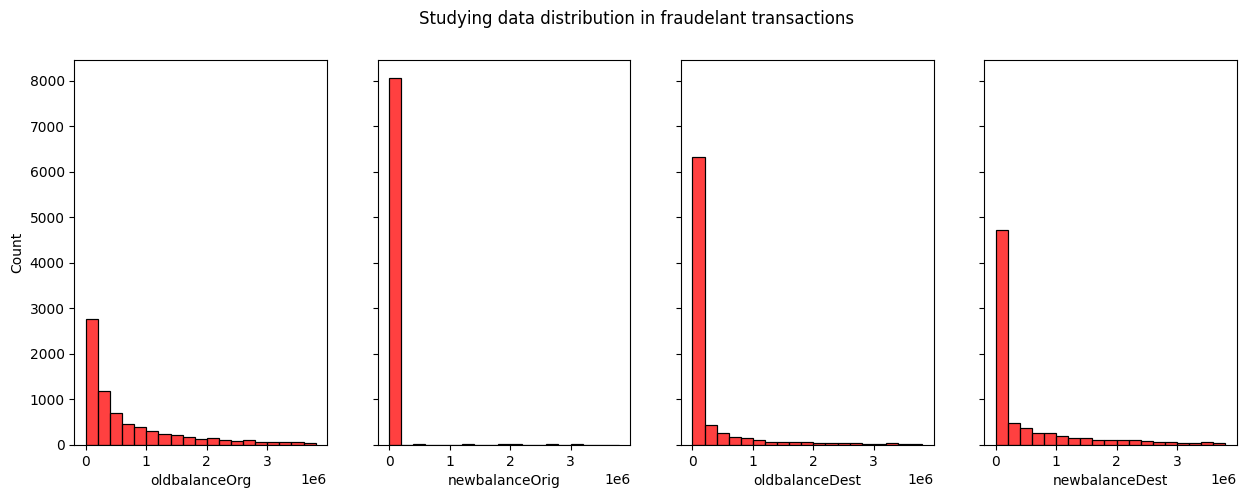

In [23]:
in_values = np.arange(start=0, stop=4000000, step=200000)
fig, axes = plt.subplots(1, 4,figsize=(15,5),sharey=True)
fig.suptitle('Studying data distribution in fraudelant transactions')
sns.histplot(ax = axes[0],x='oldbalanceOrg',bins=bin_values,data=df[df['isFraud']==1],color = 'red')
sns.histplot(ax = axes[1],x='newbalanceOrig',bins=bin_values,data=df[df['isFraud']==1],color = 'red')
sns.histplot(ax = axes[2],x='oldbalanceDest',bins=bin_values,data=df[df['isFraud']==1],color = 'red')
sns.histplot(ax = axes[3],x='newbalanceDest',bins=bin_values,data=df[df['isFraud']==1],color = 'red')

Data Distribution is right Skewed, peek at zero

[None]

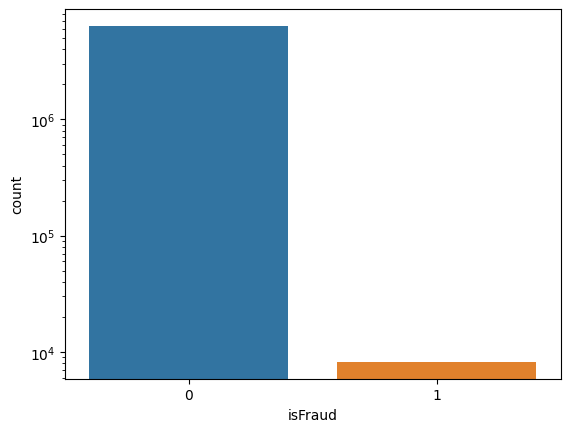

In [24]:
a = sns.countplot(x= df['isFraud'])
a.set(yscale="log")

Due to the problem Nature, fraudulant transactions are very little amount campared to total transactions  

<h2>Categorical variables study

In [25]:
df[['type', 'nameOrig', 'nameDest','isFlaggedFraud']]

,type,nameOrig,nameDest,isFlaggedFraud
0,PAYMENT,C1231006815,M1979787155,0
1,PAYMENT,C1666544295,M2044282225,0
2,TRANSFER,C1305486145,C553264065,0
3,CASH_OUT,C840083671,C38997010,0
4,PAYMENT,C2048537720,M1230701703,0
...,...,...,...,...
6362615,CASH_OUT,C786484425,C776919290,0
6362616,TRANSFER,C1529008245,C1881841831,0
6362617,CASH_OUT,C1162922333,C1365125890,0
6362618,TRANSFER,C1685995037,C2080388513,0


<h2>Numerical variables study:

<h3>Studying Outliers:

In [26]:
num_cols = ['oldbalanceOrg', 'newbalanceOrig',
        'oldbalanceDest', 'newbalanceDest','amount']
for col in num_cols:
    Q1,Q3 = np.percentile(df[col], [25,75])
    IQR = Q3 - Q1
    ul = Q3+1.5*IQR
    ll = Q1-1.5*IQR
    outliers = df[col][(df[col] > ul) | (df[col] < ll)]
    print(f'{col}:{len(outliers)}')

oldbalanceOrg:1112507
newbalanceOrig:1053391
oldbalanceDest:786135
newbalanceDest:738527
amount:338078


# Type v/s Categorical Data (Intent to visualize Outliers)

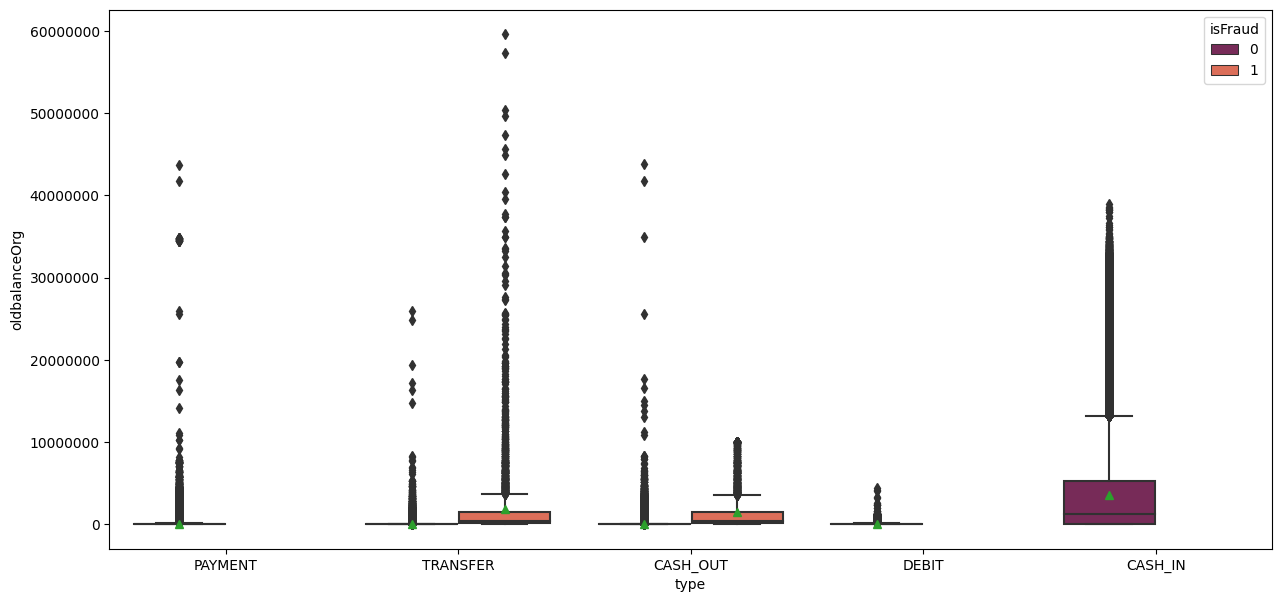

In [115]:
plt.figure(figsize=(15,7))

sns.boxplot(x = "type", y = "oldbalanceOrg",data = df, palette = 'rocket', showmeans=True, hue='isFraud')

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation

plt.show()

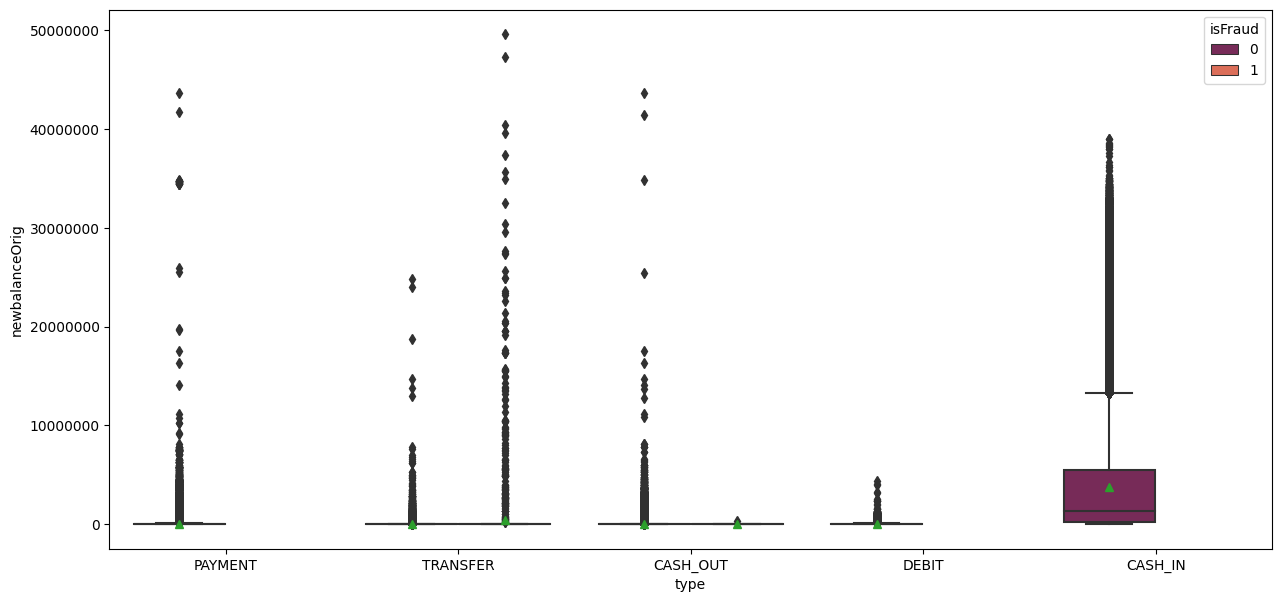

In [29]:
plt.figure(figsize=(15,7))

sns.boxplot(x = "type", y = "newbalanceOrig",data = df, palette = 'rocket', showmeans=True, hue='isFraud')

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation

plt.show()

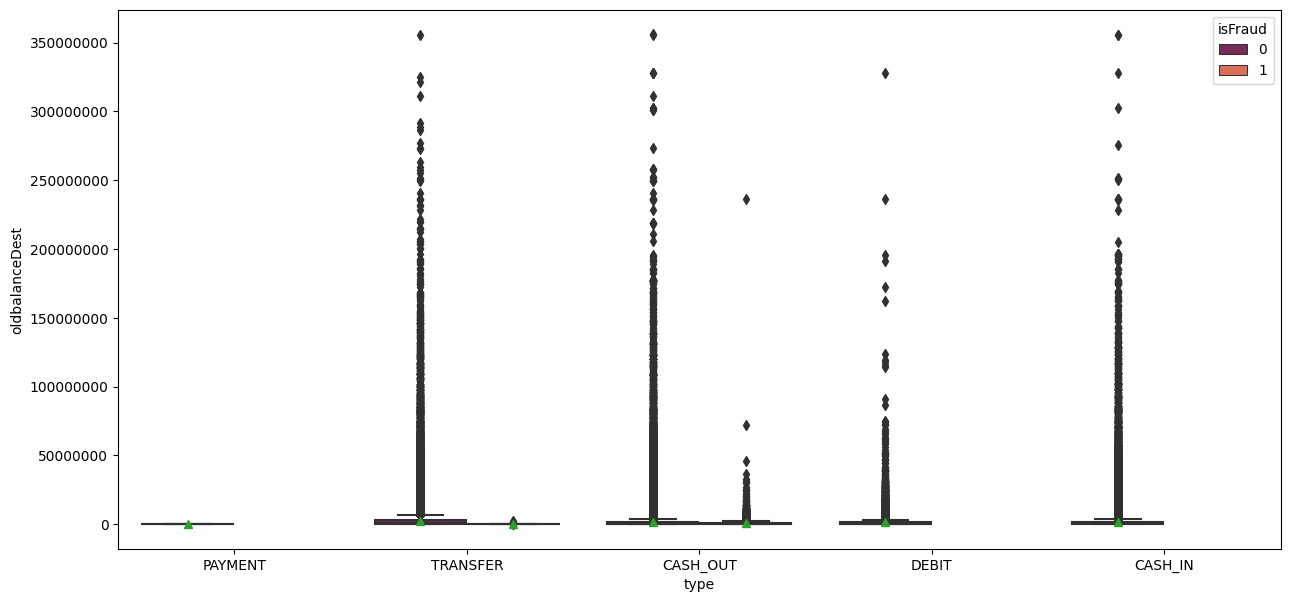

In [30]:
plt.figure(figsize=(15,7))

sns.boxplot(x = "type", y = "oldbalanceDest",data = df, palette = 'rocket', showmeans=True, hue='isFraud')

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation

plt.show()

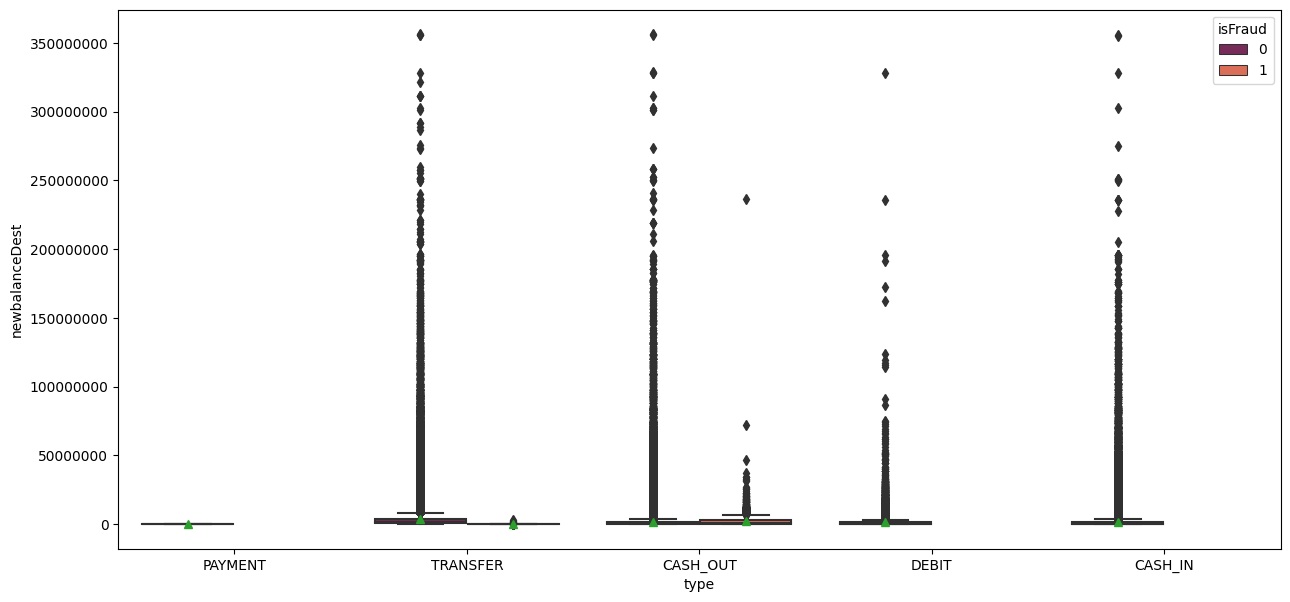

In [31]:
plt.figure(figsize=(15,7))

sns.boxplot(x = "type", y = "newbalanceDest",data = df, palette = 'rocket', showmeans=True, hue='isFraud')

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation

plt.show()

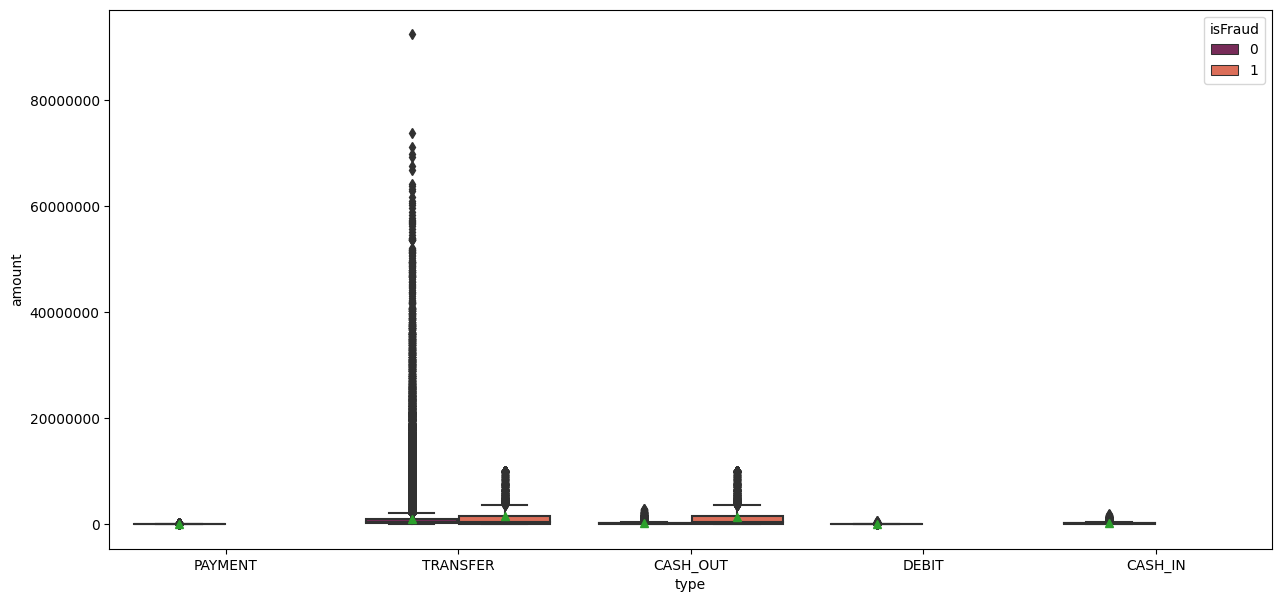

In [32]:
plt.figure(figsize=(15,7))

sns.boxplot(x = "type", y = "amount",data = df, palette = 'rocket', showmeans=True, hue='isFraud')

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation

plt.show()

Above plots points that the data is highly unbalanced.

And the data can be balanced by either of following approach;
1. Undersampling
2. Oversampling
3. SMOTE analysis

##Normalizing categorical data

In [53]:
##Data distribution
#df.drop(['nameOrig', 'nameDest'], axis = 1, inplace=True)
df = pd.get_dummies(df)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day_of_month,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,PAYMENT_PAYMENT,TRANSFER_TRANSFER,CASH_OUT_CASH_OUT,DEBIT_DEBIT,CASH_IN_CASH_IN
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,1.0,0,0,0,1,0,1,0,0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1.0,0,0,0,1,0,1,0,0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,1.0,0,0,0,0,1,0,1,0,0,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1.0,0,1,0,0,0,0,0,1,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,1.0,0,0,0,1,0,1,0,0,0,0


## Data Distribution

In [55]:
X = df.drop(['isFraud'], axis=1)  
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)

df_train = X_train.join(y_train)
df_test = X_test.join(y_test)

df_majority = df_train[df_train.isFraud == 0]
df_minority = df_train[df_train.isFraud == 1]

print("-----------")
print("Majority : ", df_majority.isFraud.count())
print("-----------")
print("Minortiy : ", df_minority.isFraud.count())
print("-----------")
print(df_train.isFraud.value_counts())

-----------
Majority :  4448085
-----------
Minortiy :  5749
-----------
0    4448085
1       5749
Name: isFraud, dtype: int64


# Oversampling

In [65]:
df_minority_upsampled = resample(df_minority, replace=True, n_samples = 4448085, random_state= 42) # reproducible results

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

df_upsampled.isFraud.value_counts()

0    4448085
1    4448085
Name: isFraud, dtype: int64

## Undersampling

In [69]:
df_majority_downsampled = resample(df_majority, replace=False, n_samples = 5749, random_state= 42) # reproducible results

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_downsampled.isFraud.value_counts()

0    5749
1    5749
Name: isFraud, dtype: int64

## SMOTE

In [75]:
X_smote, y_smote = SMOTE(random_state=42).fit_resample(X_train, y_train)

print("#Y_smote : ",len(y_smote))
print("#X_smote : ",len(X_smote))

#Y_smote :  8896170
#X_smote :  8896170


## Model Evaluation function

In [79]:
def model_eval(algo, Xtrain,ytrain,Xtest,ytest):
    from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,classification_report

    algo.fit(Xtrain,ytrain)
    y_pred = algo.predict(Xtrain)
    y_train_prob = algo.predict_proba(Xtrain)[:,1]

    #print('confusion matrix-train\n',confusion_matrix(ytrain,y_pred))
    print('Overall Train Accuracy',accuracy_score(ytrain,y_pred))
    print('Train AUC Score',roc_auc_score(ytrain,y_train_prob))

    y_test_pred = algo.predict(Xtest)
    y_test_prob = algo.predict_proba(Xtest)[:,1]


    #print('confusion matrix-test\n',confusion_matrix(ytest,y_test_pred))
    print('Overall Test Accuracy',accuracy_score(ytest,y_test_pred))
    print('Test AUC Score',roc_auc_score(ytest,y_test_prob))
    print('Classification Report of Test\n',  classification_report(ytest, y_test_pred))


    kf = KFold(n_splits = 5,shuffle = True,random_state = 42)
    score=[]
    for train_idx,test_idx in kf.split(Xtrain,ytrain):
        xtrain_k,xtest_k = Xtrain.iloc[train_idx,:],Xtrain.iloc[test_idx,:]
        ytrain_k,ytest_k = ytrain.iloc[train_idx],ytrain.iloc[test_idx]
        algo.fit(xtrain_k,ytrain_k)
        y_pred_k = algo.predict(xtest_k)
        roc = roc_auc_score(ytest_k,y_pred_k)
        score.append(roc)
    print('K-Fold scores: %0.03f (+/- %0.5f)' % (np.mean(score),np.var(score,ddof=1)))

    f,ax =  plt.subplots(1,2,figsize=(15,7))
    ConfMatrix = confusion_matrix(ytest,y_test_pred)
    sns.heatmap(ConfMatrix,annot=True, cmap='YlGnBu', fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'],linewidths=.5,ax = ax[0])
    ax[0].set_ylabel('True label')
    ax[0].set_xlabel('Predicted label')
    ax[0].set_title('Confusion Matrix')

    global fpr,tpr,thresholds
    fpr,tpr,thresholds = roc_curve(ytest,y_test_prob)
    ax[1].plot(fpr,tpr,color = 'r')
    ax[1].plot(fpr,fpr,color = 'green')
    ax[1].set_ylabel('TPR')
    ax[1].set_xlabel('FPR')
    ax[1].set_title('ROC Curve')
    plt.show()

Data is  Normal Sampling
Overall Train Accuracy 0.5659429606042794
Train AUC Score 0.782691765107906
Overall Test Accuracy 0.5657056369860215
Test AUC Score 0.7825731959238785
Classification Report of Test
               precision    recall  f1-score   support

           0       1.00      0.57      0.72   1906322
           1       0.00      1.00      0.01      2464

    accuracy                           0.57   1908786
   macro avg       0.50      0.78      0.36   1908786
weighted avg       1.00      0.57      0.72   1908786

K-Fold scores: 0.783 (+/- 0.00000)


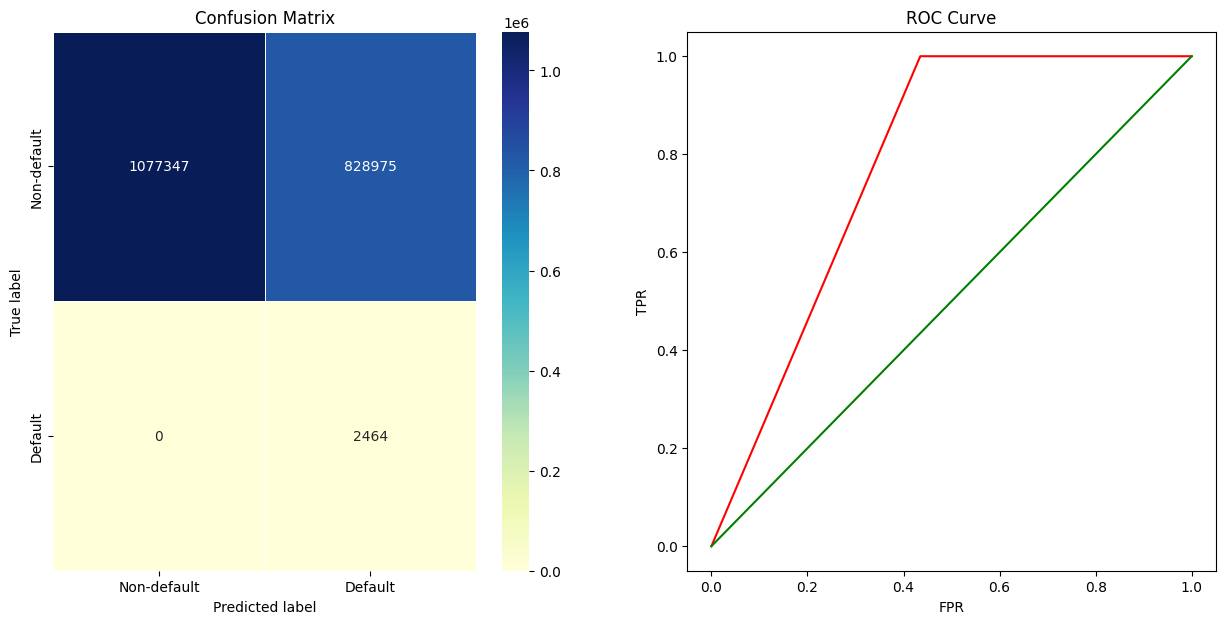

____________________________________________________________
Data is  Over Sampling
Overall Train Accuracy 0.7826908658445151
Train AUC Score 0.7826910906603628
Overall Test Accuracy 0.5657056369860215
Test AUC Score 0.7825721467831772
Classification Report of Test
               precision    recall  f1-score   support

           0       1.00      0.57      0.72   1906322
           1       0.00      1.00      0.01      2464

    accuracy                           0.57   1908786
   macro avg       0.50      0.78      0.36   1908786
weighted avg       1.00      0.57      0.72   1908786

K-Fold scores: 0.783 (+/- 0.00000)


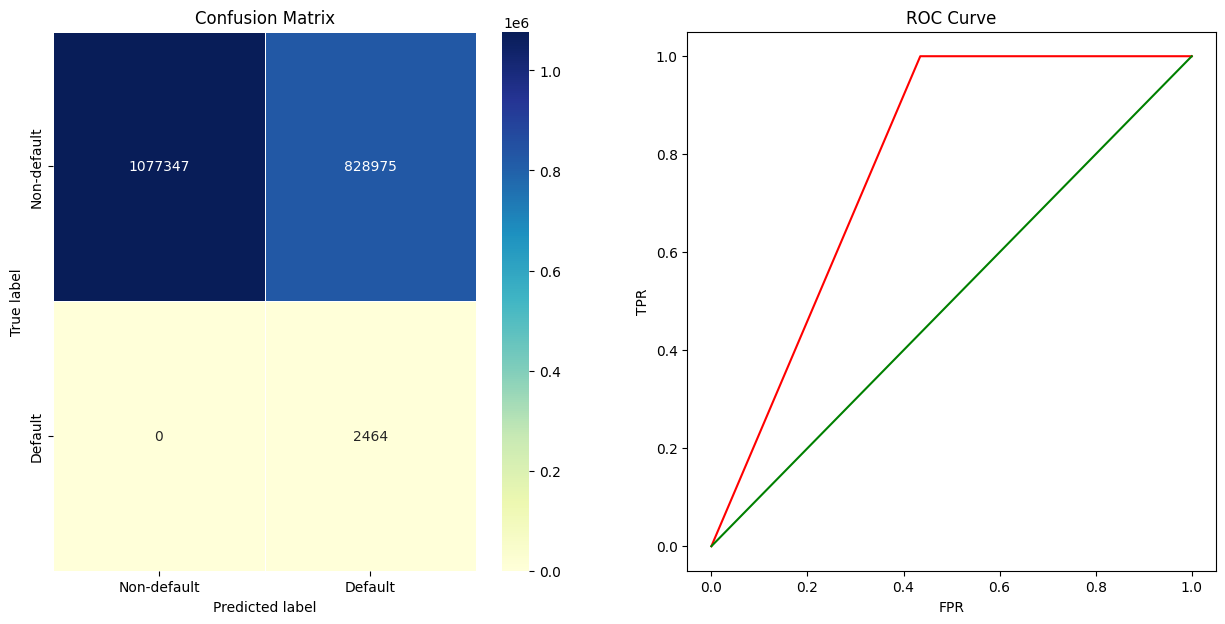

____________________________________________________________
Data is  Under Sampling
Overall Train Accuracy 0.782918768481475
Train AUC Score 0.782918768481475
Overall Test Accuracy 0.5657056369860215
Test AUC Score 0.7825721467831772
Classification Report of Test
               precision    recall  f1-score   support

           0       1.00      0.57      0.72   1906322
           1       0.00      1.00      0.01      2464

    accuracy                           0.57   1908786
   macro avg       0.50      0.78      0.36   1908786
weighted avg       1.00      0.57      0.72   1908786

K-Fold scores: 0.783 (+/- 0.00010)


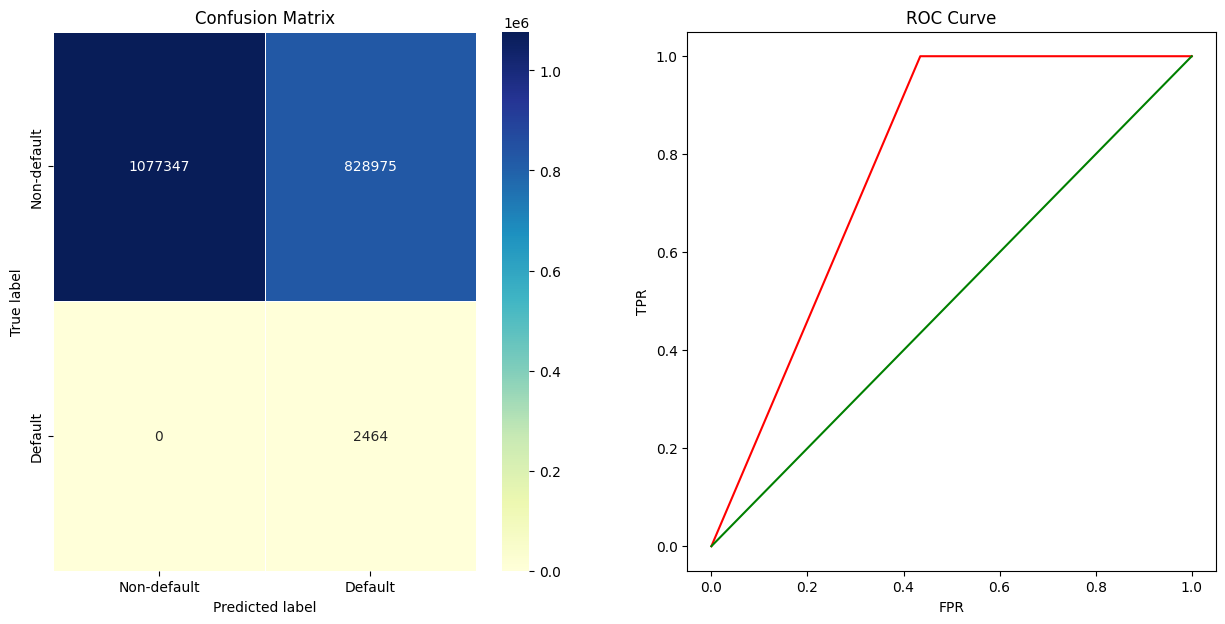

____________________________________________________________
Data is  SMOTE
Overall Train Accuracy 0.7826923271475252
Train AUC Score 0.7828927954959981
Overall Test Accuracy 0.565951866788629
Test AUC Score 0.7829178386442583
Classification Report of Test
               precision    recall  f1-score   support

           0       1.00      0.57      0.72   1906322
           1       0.00      1.00      0.01      2464

    accuracy                           0.57   1908786
   macro avg       0.50      0.78      0.36   1908786
weighted avg       1.00      0.57      0.72   1908786

K-Fold scores: 0.783 (+/- 0.00000)


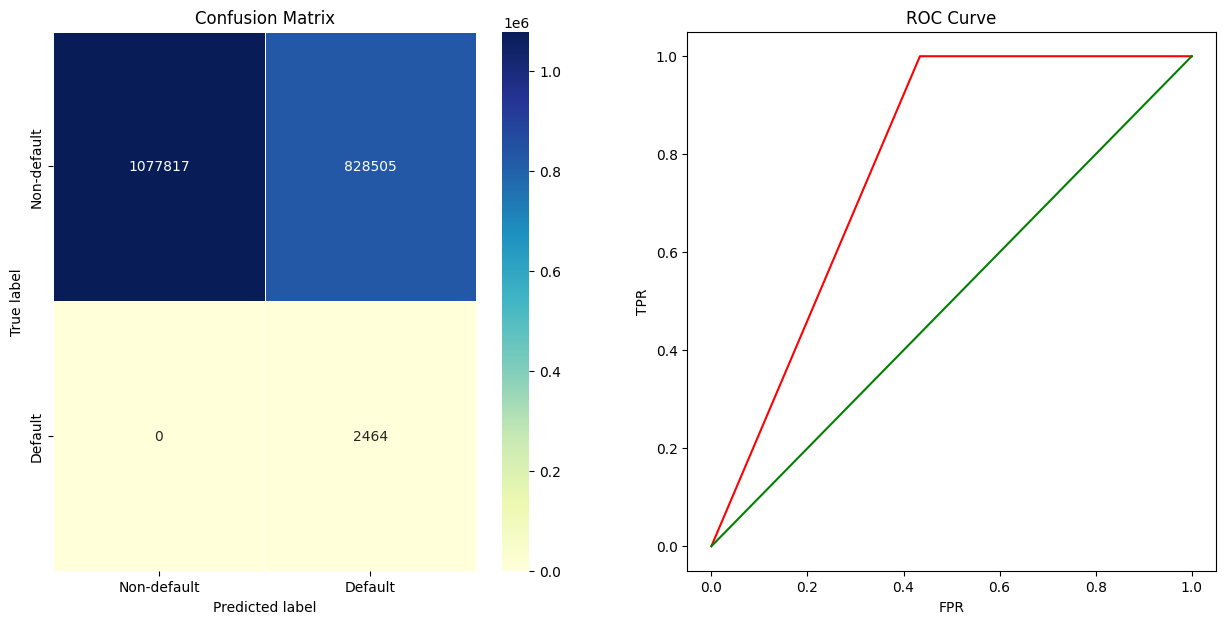

____________________________________________________________


In [82]:
xtrain_data = [X_train,df_upsampled.drop('isFraud',axis = 1),df_downsampled.drop('isFraud',axis = 1),X_smote]
ytrain_data = [y_train,df_upsampled['isFraud'],df_downsampled['isFraud'],y_smote]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']

for i,j,k in zip(xtrain_data,ytrain_data,name):
    print('Data is ',k)
    ss = StandardScaler()
    a = ss.fit_transform(i)
    xts = pd.DataFrame(a,columns = i.columns)
    b = ss.transform(X_test)
    model_eval(GaussianNB(), xts,j,b,y_test)
    print("_" * 60)

In [ ]:
xtrain_data = [X_train,df_upsampled.drop('isFraud',axis = 1),df_downsampled.drop('isFraud',axis = 1),X_smote]
ytrain_data = [y_train,df_upsampled['isFraud'],df_downsampled['isFraud'],y_smote]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']

for i,j,k in zip(xtrain_data,ytrain_data,name):
    print('Data is ',k)
    ss = StandardScaler()
    a = ss.fit_transform(i)
    xts = pd.DataFrame(a,columns = i.columns)
    b = ss.transform(X_test)
    model_eval(KNeighborsClassifier(), xts,j,b,y_test)
    print("_" * 60)

Data is  Normal Sampling


# Modeling
## Performance measures:


In [34]:
def printScores(y_test, y_pred):
    print('Confusion matrix:\n',confusion_matrix(y_test, y_pred))
    print('accuracy_score',accuracy_score(y_test, y_pred))
    print('Recall_score',recall_score(y_test, y_pred))
    print('precision_score',precision_score(y_test, y_pred))
    print('f1_score',f1_score(y_test,y_pred))    

In [35]:
knn_clf = KNeighborsClassifier()
y_train_pred = cross_val_predict(knn_clf,X_train_cleaned,y_train, cv = 10)

In [36]:
printScores(y_train,y_train_pred)

Confusion matrix:
 [[6214  362]
 [ 474 6090]]
accuracy_score 0.9363774733637747
Recall_score 0.9277879341864717
precision_score 0.9438933663980161
f1_score 0.9357713583282116


## Grid Search on KNN

Due to the problem nature, we cannot accept high false negative rate 

In [37]:
param_grid ={'n_neighbors': range(1,30),
            'weights':['uniform','distance'],
              'algorithm':['auto','ball_tree','kd_tree'],
              'leaf_size':[1,2,3,5],
              'metric':['minkowski'],
              'p': [1,2]
              }

In [38]:
grid = GridSearchCV(knn_clf, param_grid= param_grid, cv = 10, scoring = ['precision', 'recall'],refit='recall')
grid.fit(X_train_cleaned, y_train)


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'leaf_size': [1, 2, 3, 5], 'metric': ['minkowski'],
                         'n_neighbors': range(1, 30), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             refit='recall', scoring=['precision', 'recall'])

In [39]:
grid.best_estimator_

KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)

In [40]:
knn_pred = grid.predict(X_test_cleaned)

In [41]:
printScores(y_test,knn_pred)

Confusion matrix:
 [[1552   85]
 [  94 1555]]
accuracy_score 0.9455264759586123
Recall_score 0.9429957550030321
precision_score 0.948170731707317
f1_score 0.9455761629674674


## Apply decision trees for better recal:

## Decision trees:

In [42]:
from sklearn.tree import DecisionTreeClassifier
clf_en = DecisionTreeClassifier(criterion='gini', max_depth=9, random_state=0)
tree_pred = cross_val_predict(clf_en,X_train_cleaned,y_train,cv = 10)

In [43]:
printScores(y_train,tree_pred)

Confusion matrix:
 [[6308  268]
 [  47 6517]]
accuracy_score 0.976027397260274
Recall_score 0.9928397318708104
precision_score 0.9605011053795136
f1_score 0.9764027267960147


## Grid search on decision trees:

In [44]:
params = {
'max_depth':[5,10,20],
'min_samples_split':[2,3,5,10],
'min_samples_leaf':range(10,20),
 'min_impurity_decrease': [0.0001, 0.0005, 0.001, 0.005, 0.01]
}

In [45]:
c = DecisionTreeClassifier()
clf = GridSearchCV(c,param_grid= params,scoring ='recall')

In [46]:
clf.fit(X_train_cleaned, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 10, 20],
                         'min_impurity_decrease': [0.0001, 0.0005, 0.001, 0.005,
                                                   0.01],
                         'min_samples_leaf': range(10, 20),
                         'min_samples_split': [2, 3, 5, 10]},
             scoring='recall')

In [47]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=10, min_impurity_decrease=0.001,
                       min_samples_leaf=15)

In [48]:
tree_pred = clf.predict(X_test_cleaned)
printScores(y_test, tree_pred)


Confusion matrix:
 [[1558   79]
 [   9 1640]]
accuracy_score 0.9732197200243458
Recall_score 0.9945421467556095
precision_score 0.954043048283886
f1_score 0.9738717339667459


## Decision trees gave a better false negative ratio